In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import os, sys
from scipy.stats.mstats import winsorize
from tqdm import tqdm
import seaborn as sns
import sklearn
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
from sklearn import svm
from scipy import interp
from sklearn.ensemble import RandomForestClassifier, IsolationForest, BaggingClassifier, VotingClassifier,   ExtraTreesClassifier
from imblearn.ensemble import EasyEnsembleClassifier
import warnings

warnings.filterwarnings("ignore")
plt.rcParams["font.sans-serif"] = "Times New Roman"

E:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# 禁止函数内部输出
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# 可视化 ROC-AUC 曲线

def AUC_ROC(X, model):
    # 设置图形大小
    fig = plt.figure(figsize=(14, 10))

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    # 计算 预测率
    probas = model.predict_proba(X)
    # 计算 fpr,tpr
    fpr, tpr, thresholds = roc_curve(y_validation, probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.5f)'
                                   % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

    mean_tpr /= len(X_training)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot([0, 0, 1],
             [0, 1, 1],
             lw=2,
             linestyle=':',
             color='black',
             label='perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate', size=15)
    plt.ylabel('True Positive Rate', size=15)
    plt.title('ROC-AUC Plot', size=20)
    plt.legend(loc="lower right")
    plt.show()


# 可视化混淆矩阵
def confusion(X, model):
    y_pred = model.predict(X)
    confmat = confusion_matrix(y_true=y_validation, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# 平均auc(调参用)
def avg_auc(model):
    auc_list = []
    for X_, y_, X__, y__ in zip(X_train_5, y_train_5, X_test_5, y_test_5):
        model.fit(X_, y_)
        auc = roc_auc_score(y__, model.predict_proba(X__)[:, -1])
        auc_list.append(auc)
    return np.array(auc_list)

In [3]:
# 读取数据
train_data=pd.read_csv(r"Dataset/cs-training.csv",index_col="Unnamed: 0")
test_data=pd.read_csv(r"Dataset/cs-test.csv",index_col="Unnamed: 0")
column_names=["Default","Balance_r","Age","Worse_1m", "Debt_r","Income","Credit_num","Worse_3m","Estate_num","Worse_2m","Family_num"]
train_data.columns=column_names
test_data.columns=column_names

# 数据预处理
首先我们进行数据预处理, 这部分主要包括
1. 缺失值与错误样本的侦测(暂不对缺失值做处理)

2. 离群值outlier的侦测和处理


## 缺失值与错误样本
缺失值很容易理解, 错误样本被定义为有一个标签明显是错误的样本, 对于这类样本, 我们一般认为整个样本的所有数据都是不可采用的, 因此要将其删去. 我们主要侦测两种错误样本
1. 未满18岁但有了信用记录的
2. 授信额度/总信用额度>1的

In [4]:
# null检验
null_data=pd.DataFrame(pd.isna(train_data).sum(),columns=["Null_num"])
null_data["Null_percentage"]=null_data.Null_num/(train_data.count()+null_data.Null_num)
null_data.Null_percentage=null_data.Null_percentage.apply(lambda x: format(x,".2%"))
null_data

,Null_num,Null_percentage
Default,0,0.00%
Balance_r,0,0.00%
Age,0,0.00%
Worse_1m,0,0.00%
Debt_r,0,0.00%
Income,29731,19.82%
Credit_num,0,0.00%
Worse_3m,0,0.00%
Estate_num,0,0.00%
Worse_2m,0,0.00%


上面的表格展示了数据中null的数量, 总的观察点有150000个, 而null最多的feature有接近30000个null. 占比19.82%. 因此在后面的分析我们要非常小心缺失值的存在

In [5]:
# 数据特征 summary
train_data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Default,150000.0,0.07,0.25,0.0,0.00,0.00,0.00,1.0
Balance_r,150000.0,6.05,249.76,0.0,0.03,0.15,0.56,50708.0
Age,150000.0,52.30,14.77,0.0,41.00,52.00,63.00,109.0
Worse_1m,150000.0,0.42,4.19,0.0,0.00,0.00,0.00,98.0
Debt_r,150000.0,353.01,2037.82,0.0,0.18,0.37,0.87,329664.0
Income,120269.0,6670.22,14384.67,0.0,3400.00,5400.00,8249.00,3008750.0
Credit_num,150000.0,8.45,5.15,0.0,5.00,8.00,11.00,58.0
Worse_3m,150000.0,0.27,4.17,0.0,0.00,0.00,0.00,98.0
Estate_num,150000.0,1.02,1.13,0.0,0.00,1.00,2.00,54.0
Worse_2m,150000.0,0.24,4.16,0.0,0.00,0.00,0.00,98.0


### Balance_r
一般来说, 我们认为Balance_r(授信额度/总信用额度)应该是在[0,1]的范围内取值的, 但是report的最大结果是50708. 我们有理由认为, 当Balance_r大于1时, 所得到的条目是是不可信的. 因此直接删去所有大于1的信息, 一共删去3321条.

In [6]:
train_data=train_data[~(train_data["Balance_r"]>1)]

### 不考虑未成年人的信用
一般来说, 未成年人不能办信用卡, 因此我们剔除所有未成年的数据, 一共删去1条

In [7]:
train_data = train_data[~(train_data["Age"]<20)]

## Outlier 离群值
观察各个数据的分位数和最大最小值可以看出, 每个feature都存在着outlier. 而outlier会影响我们后续预测的精度, 因此我们在这一节来处理outlier. 我们处理outlier的主要手段是
1. 画出箱型图侦测outlier
2. 发现数据有着明显的右偏的倾向, 因此先做对数变换消除部分离群值
3. 对于剩余的数据, 再进行99%的缩尾处理

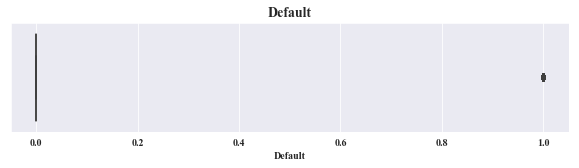

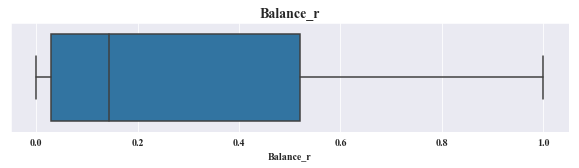

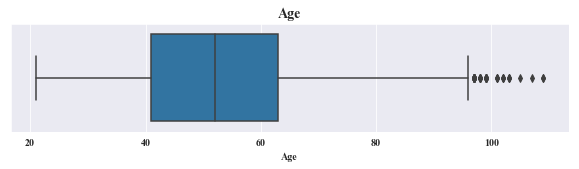

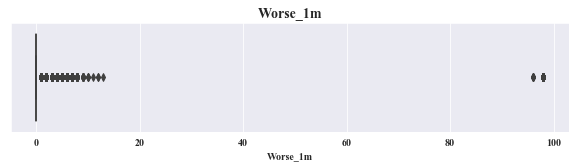

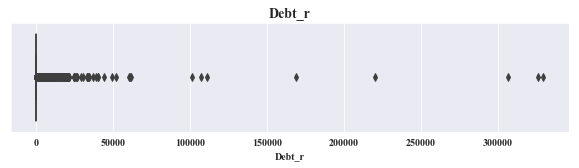

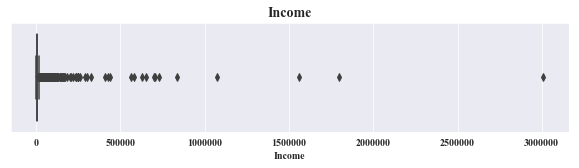

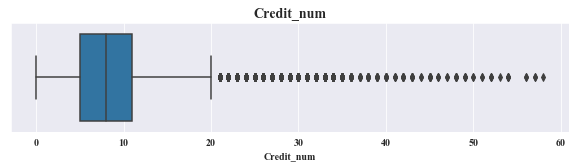

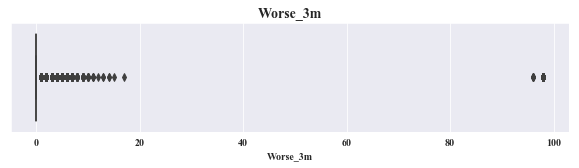

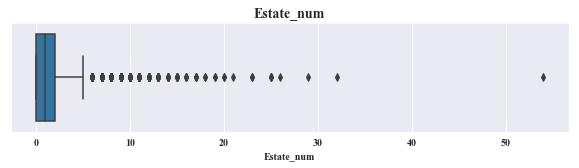

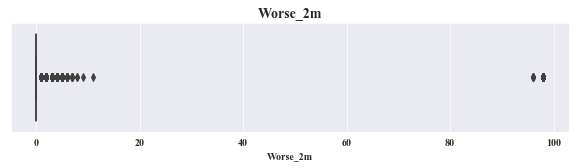

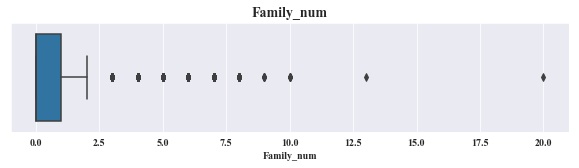

In [8]:
# 箱型图
def box_view(name):
    plt.figure(figsize=(10,2))
    sns.boxplot(data=train_data, x=name)
    plt.title(name, size=14)
    plt.show()
for name in column_names:
    box_view(name)

从箱型图可以侦测出, 部分数据具有极多的outlier, 并且有着相当明显的左偏特征. 为此, 首先计算每个数据的偏度, 对偏度较高的数据做log变换

In [9]:
# 计算偏度
skew =train_data.skew().sort_values(ascending =False )
skew_df= pd.DataFrame({'skew':skew})
skew_df

,skew
Income,113.237098
Debt_r,94.754864
Worse_2m,23.108356
Worse_3m,22.916183
Worse_1m,22.445833
Default,3.708482
Estate_num,3.503003
Family_num,1.595967
Credit_num,1.209343
Balance_r,0.957644


,skew
Worse_2m,11.445603
Worse_3m,9.624215
Worse_1m,4.542786
Debt_r,1.745026
Income,-4.364539


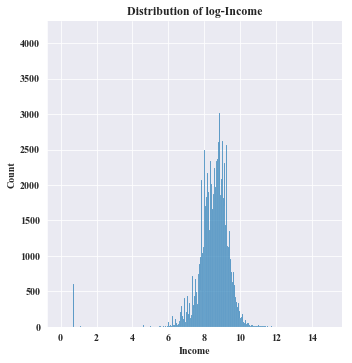

In [10]:
# 将偏度大于10的进行对数变换
skew_index=skew_df[skew_df>10].dropna().index
log_data=np.log(train_data[skew_index]+1)
skew_log =log_data.skew().sort_values(ascending =False )
skew_log=pd.DataFrame({'skew':skew_log})
sns.displot(log_data.Income)
plt.title("Distribution of log-Income", size=12)
skew_log

第一张表格给出了各个数据的偏度, 我们对所有偏度大于10的数据进行对数变换, 并计算对数变换后的偏度. 偏度的数据表明, 对数变换后的分布更加对称(log-Income的图像也验证了这一点). 因此我们采用对数变换后的数据进行分析

下面的表格展示了经过对数变换以后数据的描述性特征, 可以看出, 经过对数变换后, outlier情况有所好转, 因此我们接受对数变换的结果, 对于由分布右偏以外的其他因素引起的outlier, 我们用99%的缩尾

In [11]:
# 得到对数变换后的data, 再次summary
train_data1=train_data.copy()
train_data1[skew_index]=log_data
train_data1.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Default,146678.0,0.060,0.237,0.0,0.000,0.000,0.000,1.000
Balance_r,146678.0,0.304,0.338,0.0,0.029,0.144,0.520,1.000
Age,146678.0,52.482,14.763,21.0,41.000,52.000,63.000,109.000
Worse_1m,146678.0,0.139,0.383,0.0,0.000,0.000,0.000,4.595
Debt_r,146678.0,1.529,2.632,0.0,0.161,0.312,0.626,12.706
Income,117495.0,8.415,1.338,0.0,8.137,8.597,9.024,14.917
Credit_num,146678.0,8.500,5.159,0.0,5.000,8.000,11.000,58.000
Worse_3m,146678.0,0.051,0.283,0.0,0.000,0.000,0.000,4.595
Estate_num,146678.0,1.026,1.132,0.0,0.000,1.000,2.000,54.000
Worse_2m,146678.0,0.043,0.259,0.0,0.000,0.000,0.000,4.595


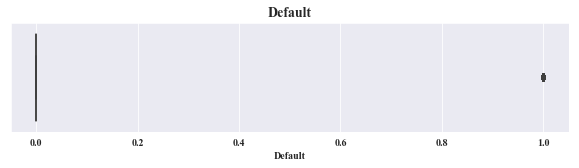

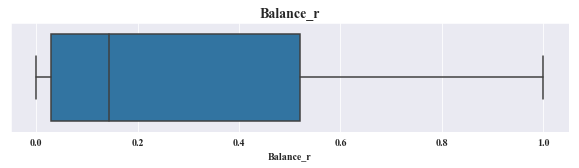

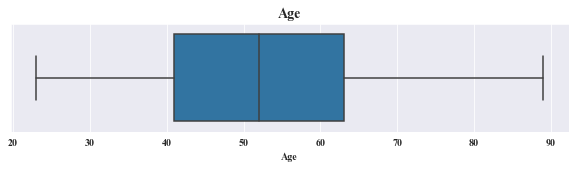

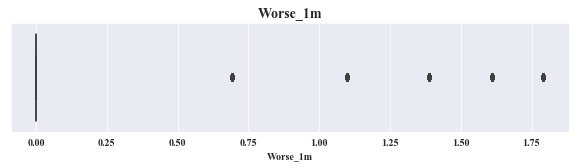

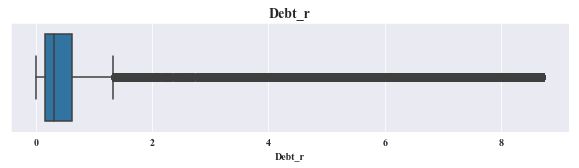

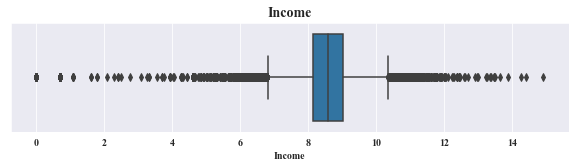

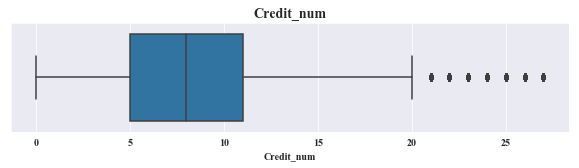

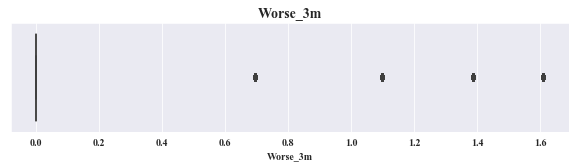

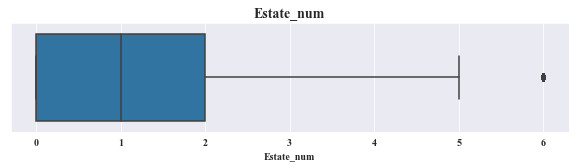

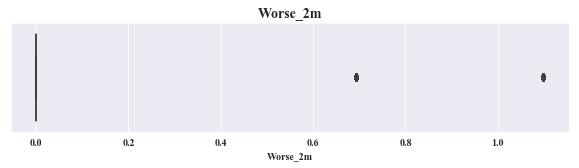

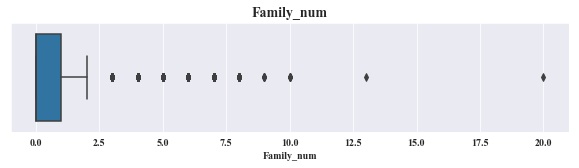

,count,mean,std,min,25%,50%,75%,max
Default,146678.0,0.060,0.237,0.0,0.000,0.000,0.000,1.000
Balance_r,146678.0,0.304,0.338,0.0,0.029,0.144,0.520,1.000
Age,146678.0,52.472,14.711,23.0,41.000,52.000,63.000,89.000
Worse_1m,146678.0,0.134,0.338,0.0,0.000,0.000,0.000,1.792
Debt_r,146678.0,1.527,2.626,0.0,0.161,0.312,0.626,8.731
Income,117495.0,8.415,1.338,0.0,8.137,8.597,9.024,14.917
Credit_num,146678.0,8.474,5.037,0.0,5.000,8.000,11.000,27.000
Worse_3m,146678.0,0.045,0.210,0.0,0.000,0.000,0.000,1.609
Estate_num,146678.0,1.015,1.044,0.0,0.000,1.000,2.000,6.000
Worse_2m,146678.0,0.036,0.168,0.0,0.000,0.000,0.000,1.099


In [13]:
# 进行99%的winsorize缩尾处理
for name in column_names:
    train_data1[name]=winsorize(train_data1[name], limits=[0.005,0.005])
def box_view(name):
    plt.figure(figsize=(10,2))
    sns.boxplot(data=train_data1, x=name)
    plt.title(name, size=14)
    plt.show()
for name in column_names:
    box_view(name)
train_data1.describe().round(3).T

# 特征分析
在这一节里, 我们主要对特征的重要性和相关性进行简单的分析. 我们的分析分为以下的几个分布
1. 分组可视化: 分组可视化是指按照违约与否分成两组, 分别对两组的其他特征进行可视化. 该可视化可以帮助我们筛选出重要的特征
2. 相关性分析: 我们主要使用散点图和配对回归图来初步展示特征之间的相关性, 产生一个直观的印象. 接着, 为了便于数据分析, 我们给出了相关系数的热量图来形象地展示相关性的大小. 最后, 我们给出了其他特征与是否违约的相关系数. 重申了特征的重要性

##  分组可视化

In [14]:
#   定义按照default分组可视化的函数
def plot_distributions(feature, discrete=True):
    '''

    :param feature: 特征名
    :param discrete: 是否是连续特征
    :return: 按照default与否分组的分布图
    '''
    fig, axes = plt.subplots(1, 2, figsize=(12,3))
    if discrete:
        sns.histplot(train_data1[feature], kde=True, label='Train',stat='density',
                 discrete=True, color='steelblue', alpha=0.6, ax=axes[0])
    else:
        sns.kdeplot(train_data1[feature], label='Train',
                color='steelblue', alpha=0.5, shade=True, edgecolor='k', ax=axes[0])
    axes[0].set_title('Distr of Train set')

    sns.boxplot(x='Default', y=feature, data=train_data1, ax=axes[1], palette=['gold', 'tan'])

    X = train_data1[[feature]].dropna()
    MI = mutual_info_classif(X, train_data1.loc[X.index, 'Default'], discrete_features=discrete,
                             random_state=0)
    axes[1].set_title('Distribution depending on the Default\n-> Mutual Information: ' + str(round(MI[0], 7)))
    fig.suptitle('{} distributions'.format(feature), y=1.15, fontsize=16)

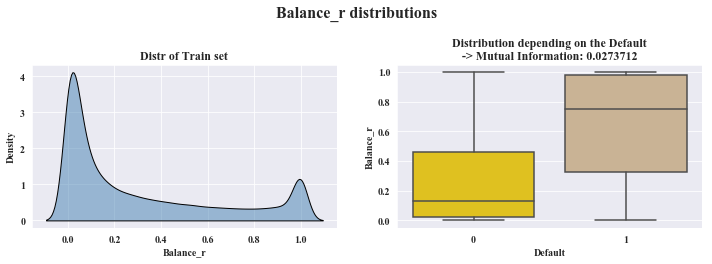

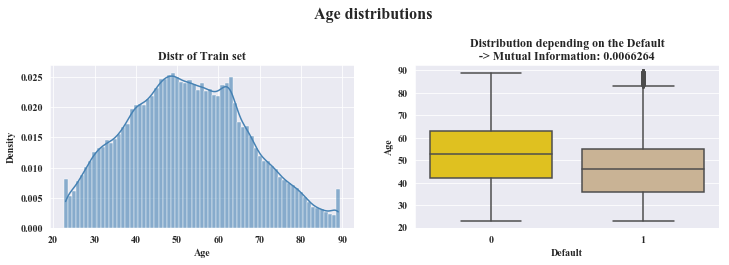

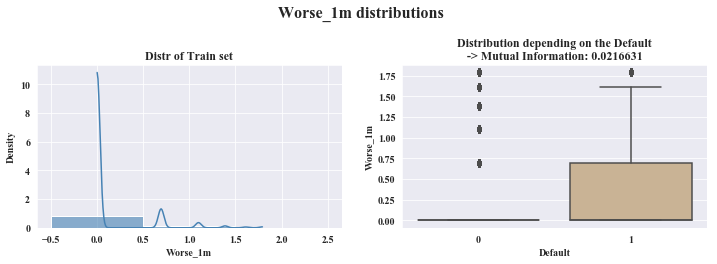

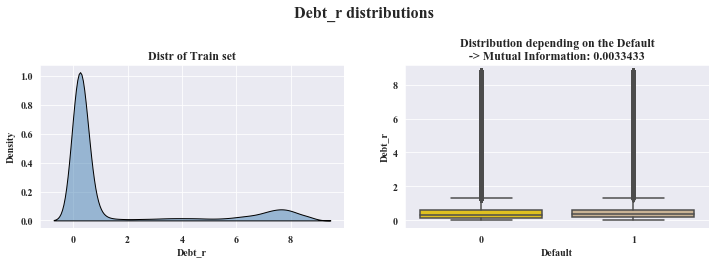

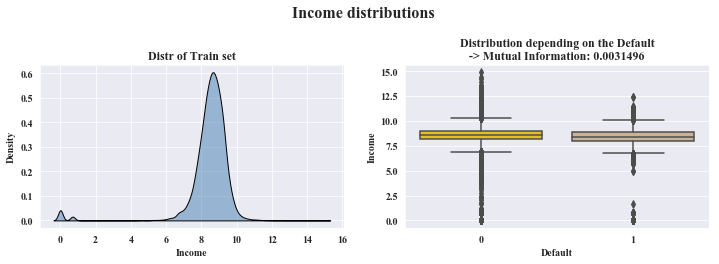

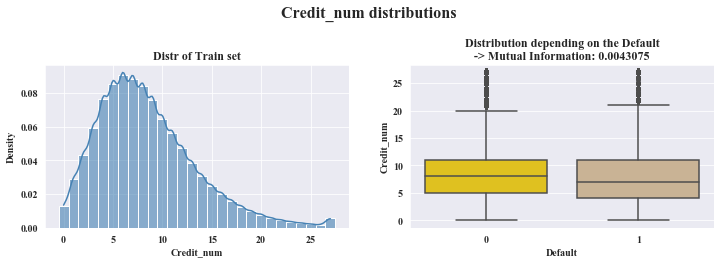

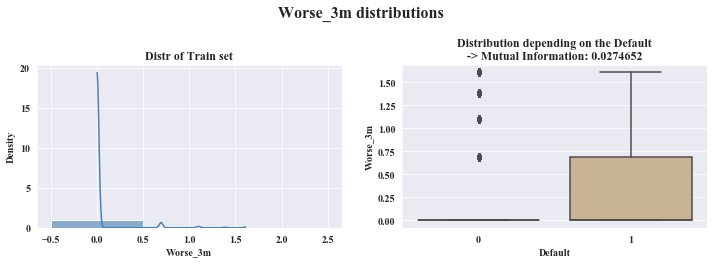

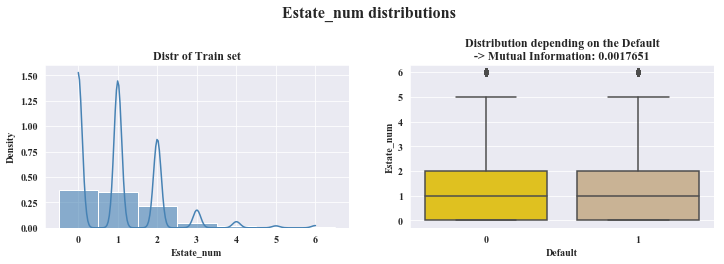

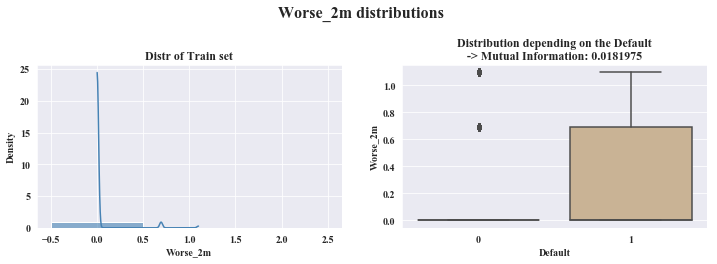

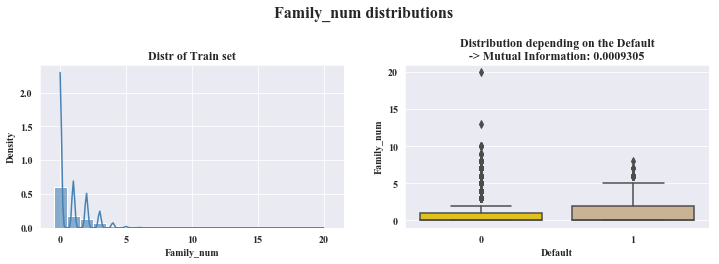

In [15]:
# 分组可视化图像
plot_distributions('Balance_r',False)
plot_distributions('Age')
plot_distributions("Worse_1m")
plot_distributions('Debt_r',False)
plot_distributions('Income',False)
plot_distributions("Credit_num")
plot_distributions("Worse_3m")
plot_distributions("Estate_num")
plot_distributions("Worse_2m")
plot_distributions('Family_num')

从上面的图片中可以得到一些基本的结论
1. Balance_r(授信额度/总信用额度)在是否违约的人群中的分布显著不同, 且MI较高, 是比较有效的特征. 从图中可以初步看出, 授信额度占比更高的违约可能性更高
2. Age在是否违约的人群中的分布显著不同, 从图中可以初步看出, 年轻人的违约可能性更高
3. worse_1m, worse_2m, worse_3m 这三个逾期次数是非常有效的特征, 在组间有显著的差异. 从图中可以初步看出, 过去逾期次数多的更容易违约
4. 剩余的几个指标仅从图中来看, 还不能看出存在明显的差异. 需要进一步进行分析


## 相关性分析

### 散点图

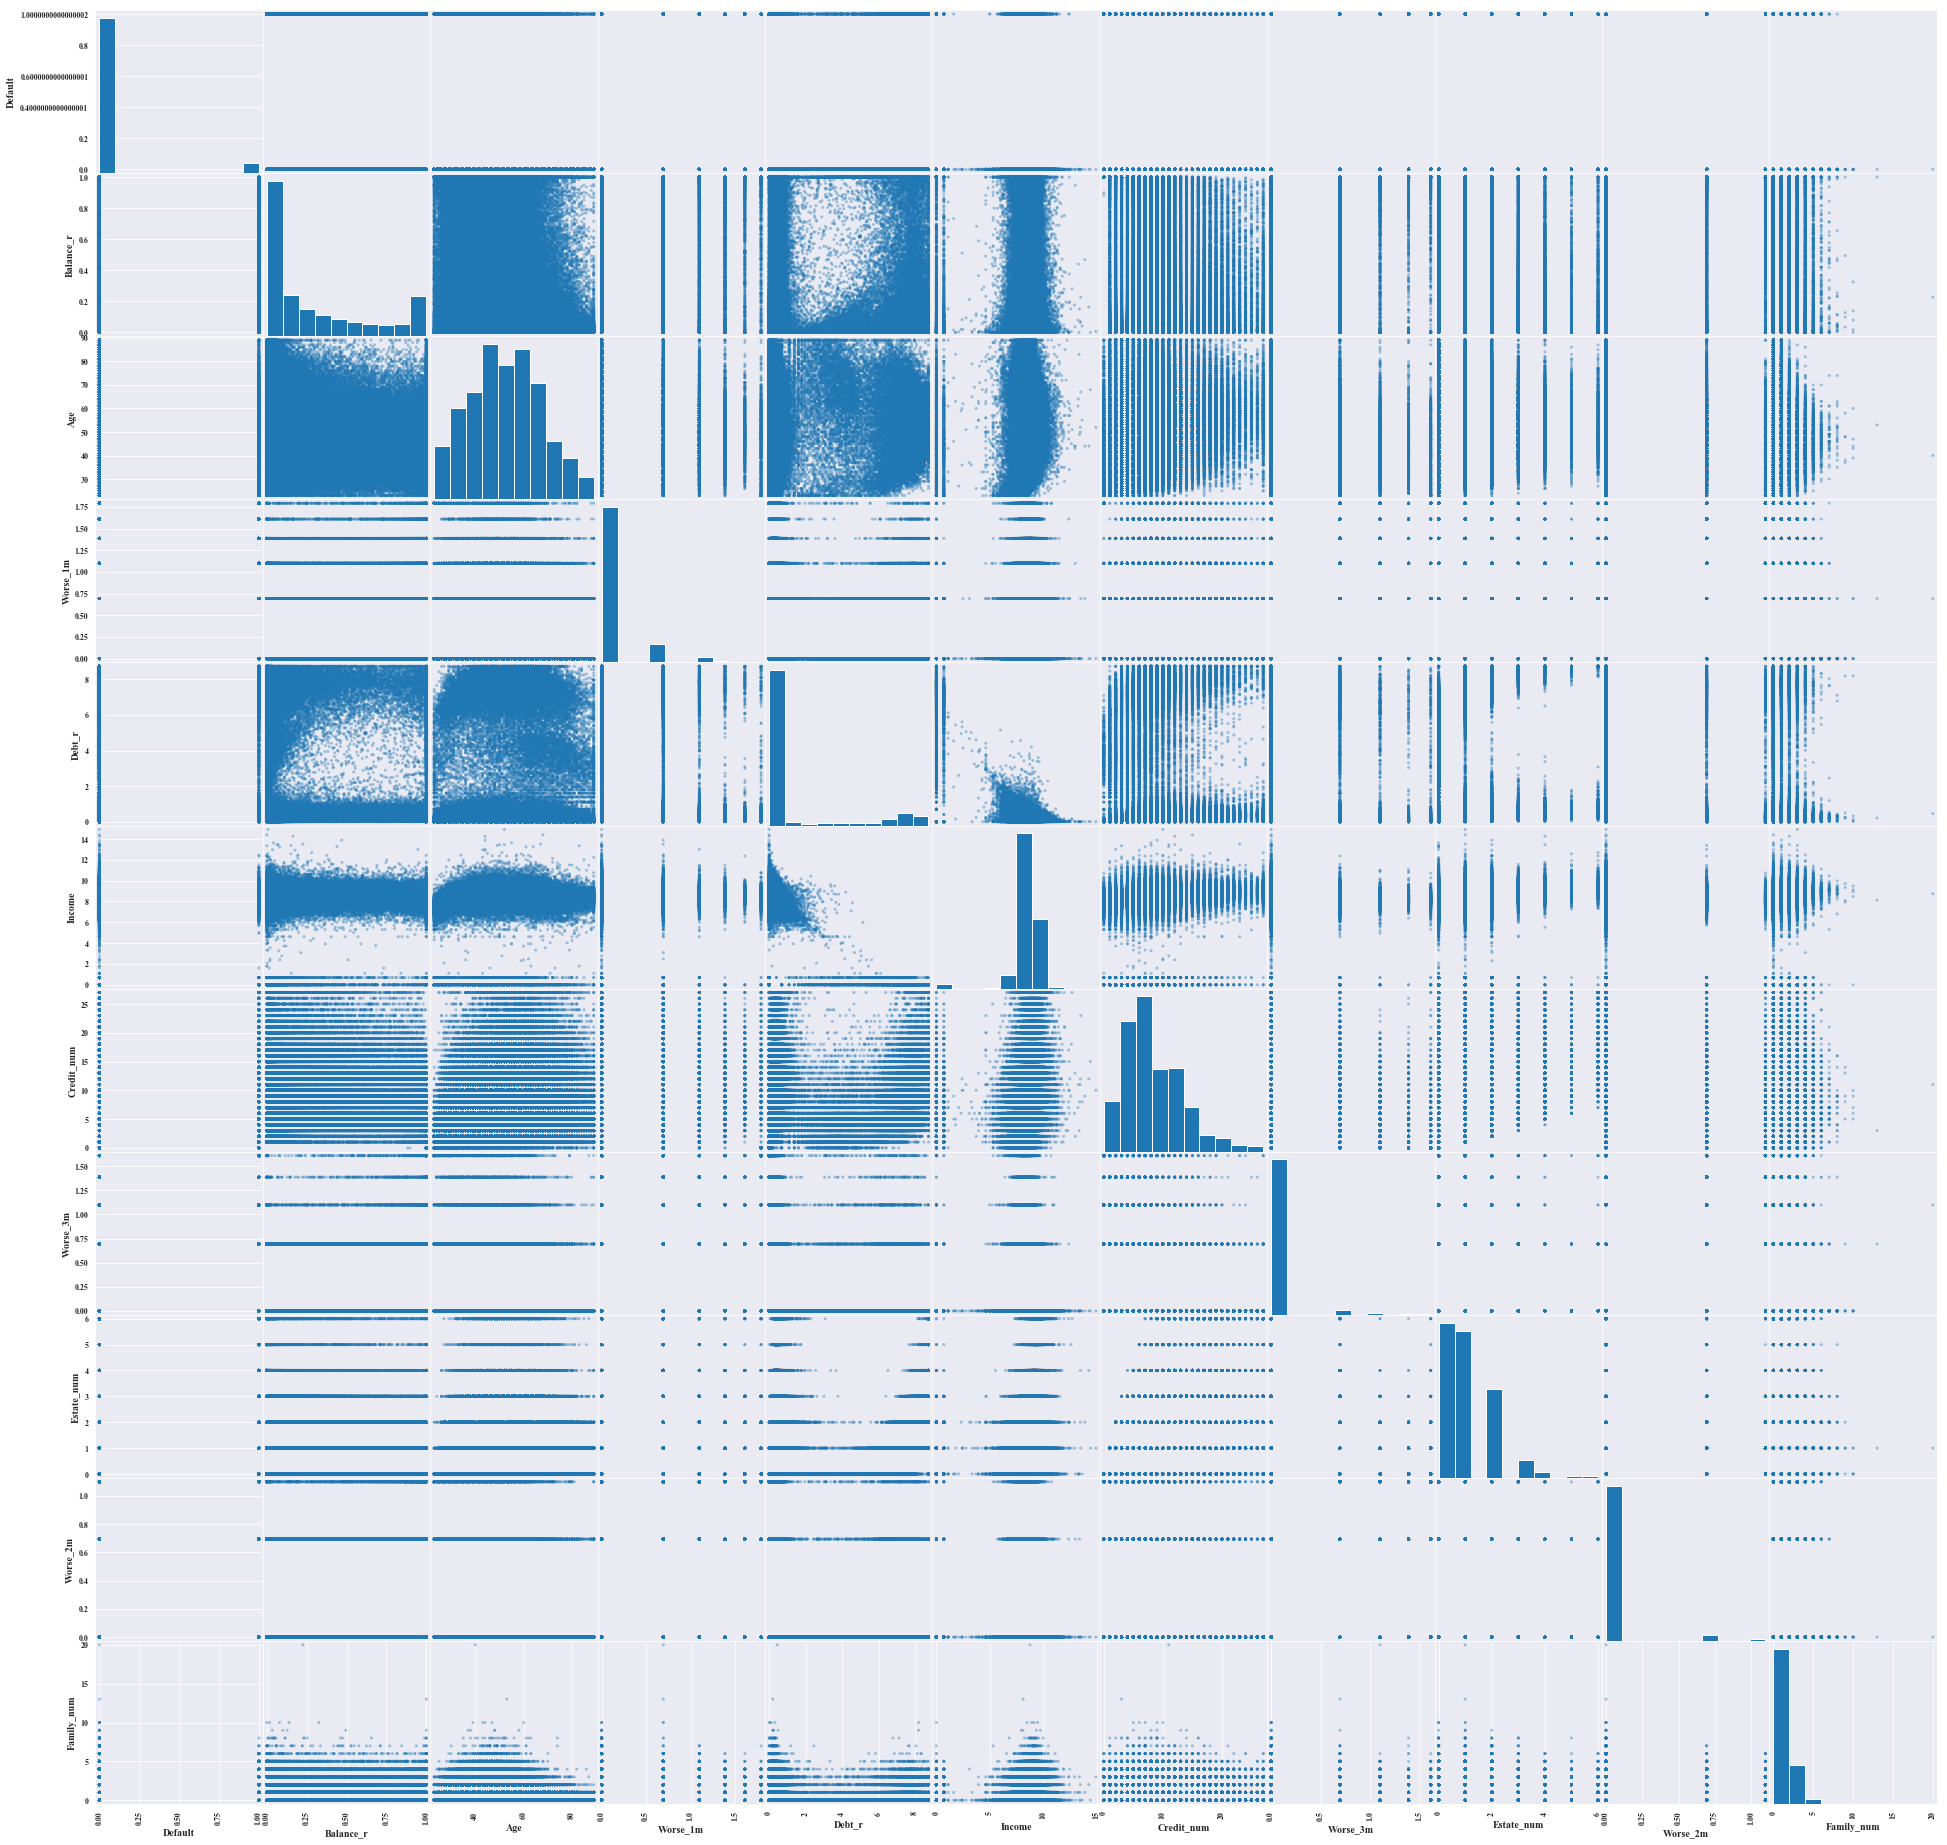

In [16]:
#画出变量两两之间的散点图
with HiddenPrints():
    pd.plotting.scatter_matrix(train_data1[column_names],figsize=(33,33),diagonal='hist',alpha = 0.4,range_padding=0.05)

### Pair plot
其中下半部分包含回归图，以更好的观察相关关系。

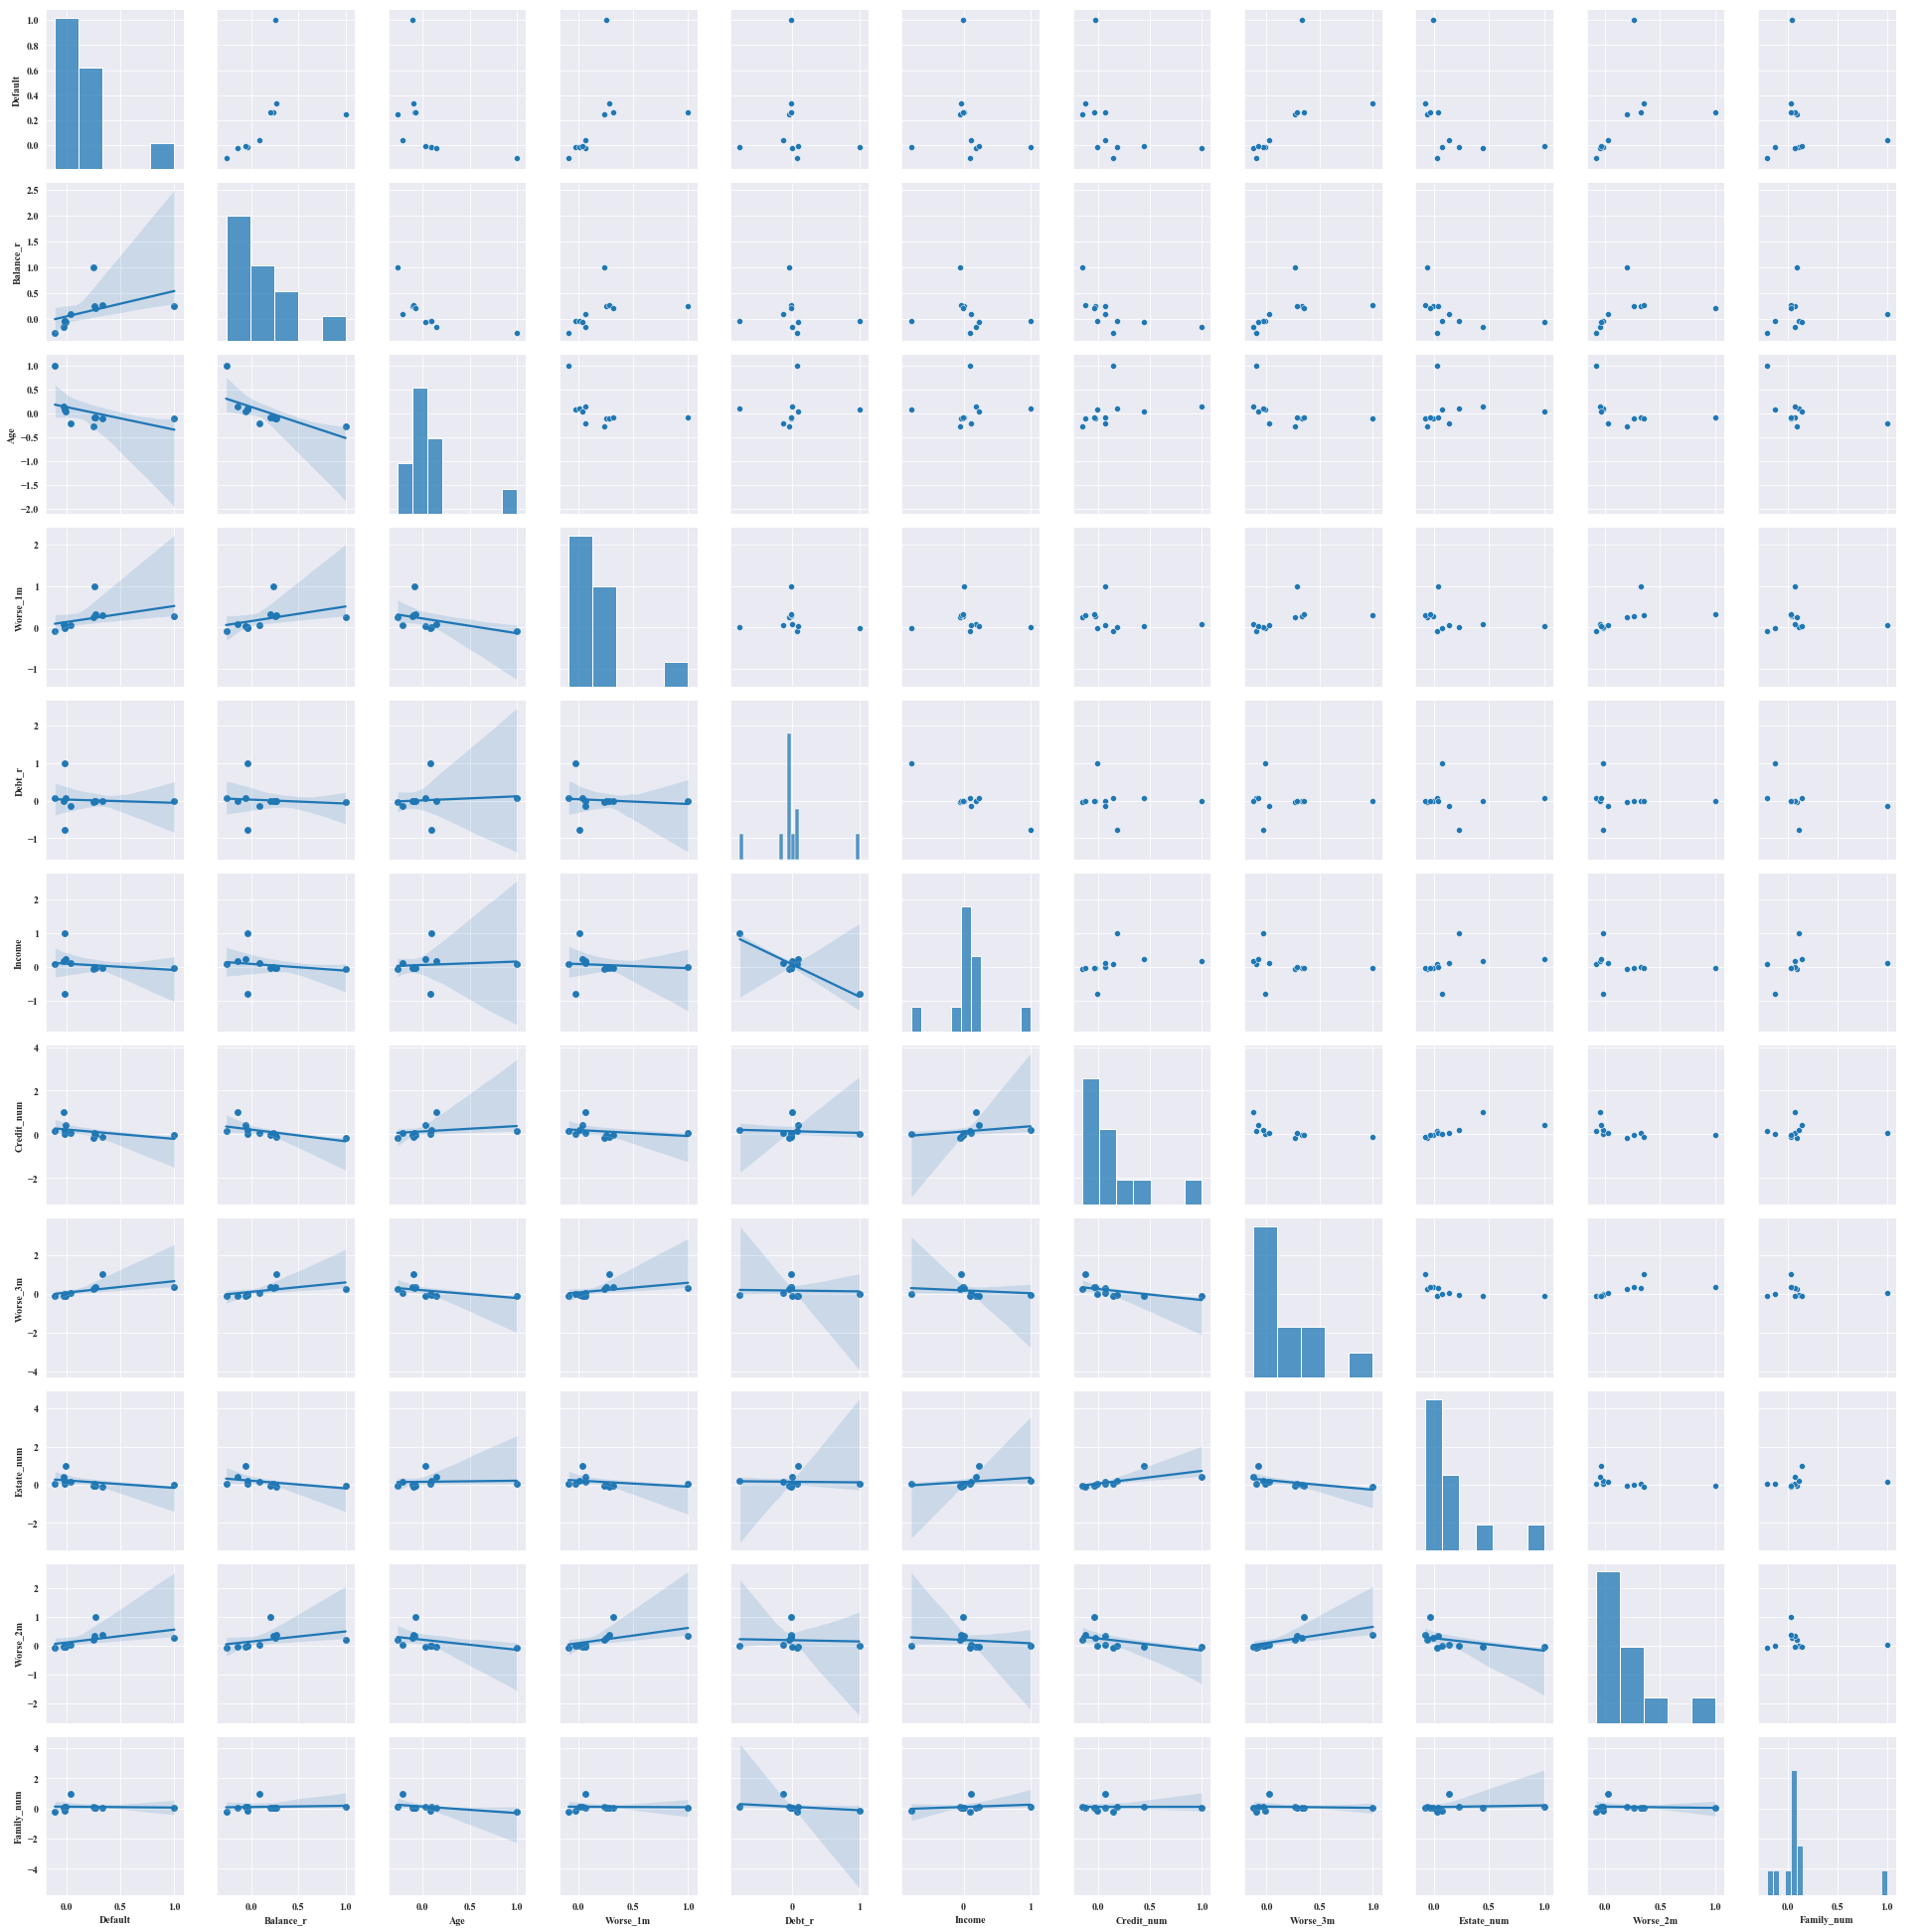

In [17]:
train_data1_corr=train_data1.corr()
g = sns.pairplot(train_data1_corr)
g.map_lower(sns.regplot)

### 相关系数表
散点图并没有那么方便观察, 我们将一幅图用一个量相关系数来描述

In [18]:
#列出两两之间相关系数
train_data1_corr

,Default,Balance_r,Age,Worse_1m,Debt_r,Income,Credit_num,Worse_3m,Estate_num,Worse_2m,Family_num
Default,1.000000,0.249453,-0.105943,0.258688,-0.017196,-0.014723,-0.023379,0.334912,-0.003960,0.265210,0.042338
Balance_r,0.249453,1.000000,-0.269487,0.236506,-0.043520,-0.047508,-0.153084,0.267695,-0.063363,0.196870,0.086411
Age,-0.105943,-0.269487,1.000000,-0.085301,0.076348,0.090564,0.144867,-0.100097,0.028143,-0.080358,-0.215539
Worse_1m,0.258688,0.236506,-0.085301,1.000000,-0.022406,0.011853,0.070692,0.282912,0.037586,0.323906,0.063373
Debt_r,-0.017196,-0.043520,0.076348,-0.022406,1.000000,-0.786310,-0.005292,-0.014914,0.078677,-0.012779,-0.133257
Income,-0.014723,-0.047508,0.090564,0.011853,-0.786310,1.000000,0.185632,-0.033176,0.224141,-0.015786,0.107689
Credit_num,-0.023379,-0.153084,0.144867,0.070692,-0.005292,0.185632,1.000000,-0.123107,0.442669,-0.041826,0.069246
Worse_3m,0.334912,0.267695,-0.100097,0.282912,-0.014914,-0.033176,-0.123107,1.000000,-0.083118,0.353371,0.024206
Estate_num,-0.003960,-0.063363,0.028143,0.037586,0.078677,0.224141,0.442669,-0.083118,1.000000,-0.032218,0.136800
Worse_2m,0.265210,0.196870,-0.080358,0.323906,-0.012779,-0.015786,-0.041826,0.353371,-0.032218,1.000000,0.030905


### 热量图
将相关系数可视化, 画出热量图便于观察变量间的相关关系

AttributeError: Unknown property labels

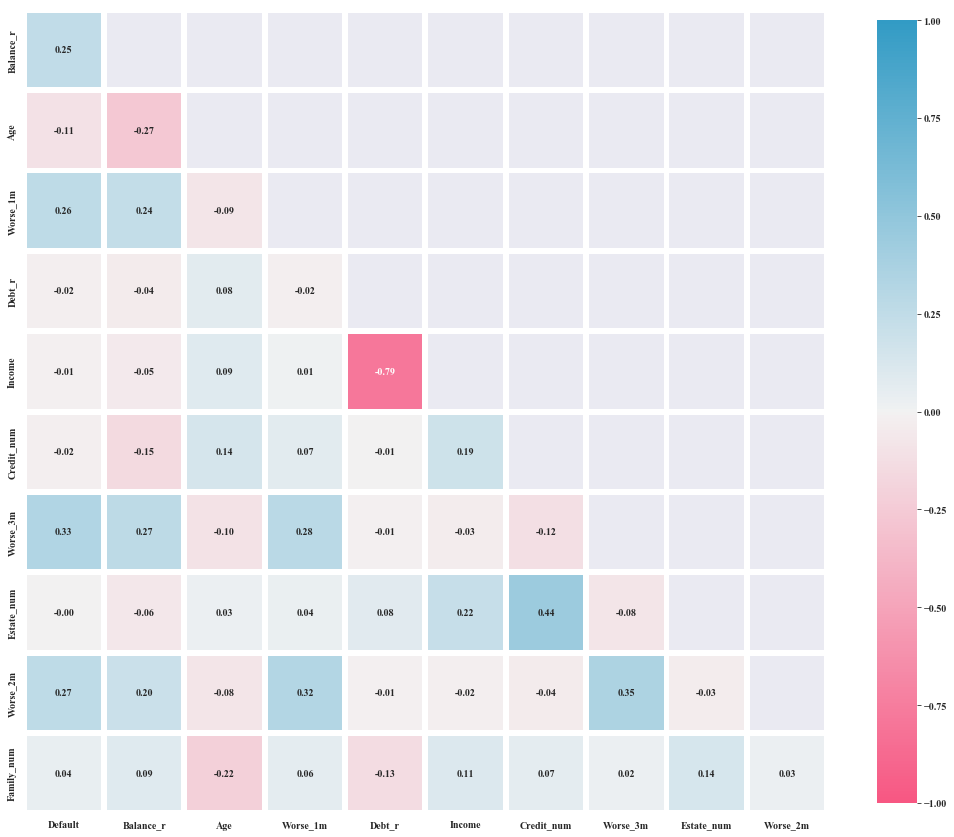

In [26]:
mask=np.triu(np.ones_like(train_data1_corr,dtype=np.bool_))
mask=mask[1:,:-1]
corr=train_data1_corr.iloc[1:,:-1].copy()
plt.figure(figsize=(18,18))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
               linewidths=5, cmap=cmap, vmin=-1, vmax=1,
               cbar_kws={"shrink": .8}, square=True)
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
plt.title('CORRELATION MATRIX', loc='left', fontsize=18)
plt.show()

### 只保留target变量的相关系数
最后, 我们只看每个变量和target的相关系数

In [ ]:
### default和其他变量的相关系数
train_data1.corr()['Default'][1:].plot.barh(figsize=(8,6),alpha=.6,color='darkblue')
plt.xlim(-.3,.3)
x_range=np.arange(-0.3,0.3,0.05)
plt.xticks(x_range, [str((100*i).round(3))+'%' for i in x_range],fontsize=12)
_=plt.title('Correlation between target and other variables',fontsize=14)

# 特征提取
(等大家整完)

In [47]:
from sklearn.cluster import KMeans

data_column_names = ["Balance_r", "Age", "Worse_1m", "Debt_r", "Income", "Credit_num", "Worse_3m", "Estate_num",
                     "Worse_2m", "Family_num"]
data = train_data[data_column_names]
#去除无效值
data = data.dropna()
#归一化
from sklearn.preprocessing import MinMaxScaler

preprocess = MinMaxScaler()
data = pd.DataFrame(preprocess.fit_transform(data))

data


,0,1,2,3,4,5,6,7,8,9
0,0.766127,0.292683,0.020408,1.314070e-05,0.003031,0.224138,0.000000,0.111111,0.0,0.10
1,0.957151,0.231707,0.000000,1.994488e-06,0.000864,0.068966,0.000000,0.000000,0.0,0.05
2,0.658180,0.207317,0.010204,1.392869e-06,0.001011,0.034483,0.010204,0.000000,0.0,0.00
3,0.233810,0.109756,0.000000,5.899484e-07,0.001097,0.086207,0.000000,0.000000,0.0,0.00
4,0.907239,0.341463,0.010204,4.079058e-07,0.021134,0.120690,0.000000,0.018519,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...
117490,0.385742,0.353659,0.000000,6.616200e-06,0.001130,0.120690,0.000000,0.000000,0.0,0.00
117491,0.040674,0.646341,0.000000,3.684238e-06,0.000698,0.068966,0.000000,0.018519,0.0,0.00
117492,0.299745,0.280488,0.000000,1.172645e-05,0.001856,0.068966,0.000000,0.018519,0.0,0.10
117493,0.000000,0.109756,0.000000,0.000000e+00,0.001900,0.068966,0.000000,0.000000,0.0,0.00


In [48]:
#K-Means聚成4类

model = KMeans(n_clusters=4)
model.fit(data)
labels = model.labels_
#加上聚类的label列

r = pd.concat([data, pd.Series(model.labels_, index=data.index)], axis=1)
r.columns = list(data.columns) + [u'label']
r


,0,1,2,3,4,5,6,7,8,9,label
0,0.766127,0.292683,0.020408,1.314070e-05,0.003031,0.224138,0.000000,0.111111,0.0,0.10,2
1,0.957151,0.231707,0.000000,1.994488e-06,0.000864,0.068966,0.000000,0.000000,0.0,0.05,2
2,0.658180,0.207317,0.010204,1.392869e-06,0.001011,0.034483,0.010204,0.000000,0.0,0.00,2
3,0.233810,0.109756,0.000000,5.899484e-07,0.001097,0.086207,0.000000,0.000000,0.0,0.00,1
4,0.907239,0.341463,0.010204,4.079058e-07,0.021134,0.120690,0.000000,0.018519,0.0,0.00,2
...,...,...,...,...,...,...,...,...,...,...,...
117490,0.385742,0.353659,0.000000,6.616200e-06,0.001130,0.120690,0.000000,0.000000,0.0,0.00,0
117491,0.040674,0.646341,0.000000,3.684238e-06,0.000698,0.068966,0.000000,0.018519,0.0,0.00,3
117492,0.299745,0.280488,0.000000,1.172645e-05,0.001856,0.068966,0.000000,0.018519,0.0,0.10,0
117493,0.000000,0.109756,0.000000,0.000000e+00,0.001900,0.068966,0.000000,0.000000,0.0,0.00,1


In [49]:
#统计下各label占比
import collections

data_count2 = collections.Counter(labels)
data_count2


Counter({2: 22277, 1: 36081, 3: 35684, 0: 23453})

Text(0.5,1,'UMAP projection of the dataset')

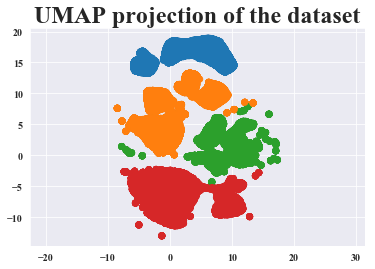

In [50]:
# T_sne降维跑不动
# 用UMap降维到两维
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(r)
#可视化
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in r.label])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=24)

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import os,sys
from scipy.stats.mstats import winsorize
import seaborn as sns
import sklearn
from sklearn.feature_selection import mutual_info_classif
plt.rcParams["font.sans-serif"]="Times New Roman"
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
# 读取数据
train_data = pd.read_csv(r"Dataset/cs-training.csv", index_col="Unnamed: 0")
test_data = pd.read_csv(r"Dataset/cs-test.csv", index_col="Unnamed: 0")
column_names = ["Default", "Balance_r", "Age", "Worse_1m", "Debt_r", "Income", "Credit_num", "Worse_3m", "Estate_num",
                "Worse_2m", "Family_num"]
train_data.columns = column_names
test_data.columns = column_names
train_data = train_data[~(train_data["Balance_r"] > 1)]
train_data = train_data[~(train_data["Age"] < 20)]
skew = train_data.skew().sort_values(ascending=False)
skew_df = pd.DataFrame({'skew': skew})
skew_index = skew_df[skew_df > 10].dropna().index
log_data = np.log(train_data[skew_index] + 1)
train_data1 = train_data.copy()
train_data1[skew_index] = log_data
for name in column_names:
    train_data1[name] = winsorize(train_data1[name], limits=[0.005, 0.005])

In [52]:
# 禁止函数内部输出
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [53]:
X=train_data1[skew_index].dropna()
pca=PCA(n_components=2)
pca.fit(X)
print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
newX=pca.fit_transform(X)

[[-0.86816758  0.49625912  0.00133052  0.00291375 -0.00129554]
 [-0.49512925 -0.86655097  0.00743228  0.03501049 -0.0515312 ]]
[2.30359268 0.21723738]
[0.84990112 0.08014884]


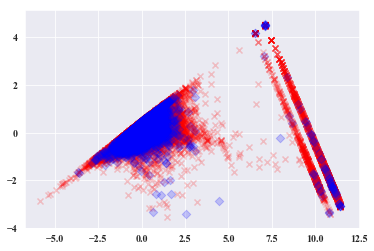

In [54]:
train_without_na=train_data1.dropna()
train_without_na.reset_index(drop=True, inplace=True)
bad_credit_x,bad_credit_y=[],[]
good_credit_x,good_credit_y=[],[]
for i in range(len(train_without_na['Default'])):
    if train_without_na.at[i,'Default']==0:
        good_credit_x.append(newX[i][0])
        good_credit_y.append(newX[i][1])
    elif train_without_na.at[i,'Default']==1:
        bad_credit_x.append(newX[i][0])
        bad_credit_y.append(newX[i][1])
with HiddenPrints():
    plt.scatter(good_credit_x,good_credit_y,c='r',marker='x',alpha=0.2)
    plt.scatter(bad_credit_x,bad_credit_y,c='b',marker='D',alpha=0.2)

# 预测部分
在这一部分, 我们主要是对违约概率进行预测. 我们主要做了以下几方面的工作
1. 填充缺失值: 为了最大限度利用样本数据(因为大约有20%的数据缺失, 太多了), 我们用xgboost方法来对缺失值进行预测
2. 比较了数据采样方式: 因为正负样本比为1:15, 因此需要考虑不平衡样本给预测带来的bias. 我们以随机森林为性能基准, 详细分析了过采样, 欠采样和混合方法. 最终选择了正负样本比为1:5的欠采样方法
3. 模型搭建与调参: 我们主要采用了两类模型, 首先是线性分类器, 包括logistics 回归和 线性 SVM. 但我们发现这两个分类器的分类效果比较一般. 接着, 我们引入了树家族, 对随机森林, 极端随机森林和XGBoost树进行了调参
4. 模型集成: 我们对树家族的模型进行了集成, 首先在每个集成的森林的基础上再次使用了bagging算法得到更好的分类器; 然后再用voting方法合成了最终的分类器

In [55]:
# 读取数据
train_data=pd.read_csv(r"Dataset/cs-training.csv",index_col="Unnamed: 0")
test_data=pd.read_csv(r"Dataset/cs-test.csv",index_col="Unnamed: 0")
column_names=["Default","Balance_r","Age","Worse_1m", "Debt_r","Income","Credit_num","Worse_3m","Estate_num","Worse_2m","Family_num"]
train_data.columns=column_names
test_data.columns=column_names
train_data=train_data[~(train_data["Balance_r"]>1)]
train_data = train_data[~(train_data["Age"]<20)]
skew =train_data.skew().sort_values(ascending =False )
skew_df= pd.DataFrame({'skew':skew})
skew_index=skew_df[skew_df>10].dropna().index
log_data=np.log(train_data[skew_index]+1)
train_data1=train_data.copy()
train_data1[skew_index]=log_data
for name in column_names:
    train_data1[name]=winsorize(train_data1[name], limits=[0.005,0.005])

## 准备工作
### 对test的数据处理
考虑到之前我们对train样本做了一定的处理, 我们必须对test的样本也做相同的处理. 不同于train_data, 对于明显有错误的值, 我们不能直接删除, 而是要将其转化为缺失值.

In [56]:
tmp_balance=test_data["Balance_r"].copy()
tmp_balance[tmp_balance>1]=np.nan
test_data["Balance_r"]=tmp_balance # 将Balance_r超过1的重新设为np.nan
test_data[skew_index]=np.log(test_data[skew_index]+1)
max_value=train_data1.max()
for name, value in max_value[1:].iteritems():
    tmp=test_data[name].copy()
    tmp[tmp>value]=value
    test_data[name]=tmp
y_train=train_data1["Default"]
X_train=train_data1.drop(['Default'], axis=1)
X_test=test_data.drop(['Default'], axis=1)

### 缺失值填充
为了最大限度地使用训练样本, 我们选择填充缺失值而不是将缺失值所在的行直接删去. 当某一个元素缺失时, 我们通过其所在行其他列上的数据来预测缺失值的值. 这里采用了xgboost方法

In [57]:
def fillna_XGB(label):
    xgbr=XGBRegressor()
    nn_data=X_train[~X_train[label].isnull()].copy()
    y_=nn_data[label]
    X_=nn_data.drop(label,axis=1)
    xgbr.fit(X_,y_)
    train_X_missing=X_train[X_train[label].isnull()].drop([label],axis=1)
    test_X_missing=X_test[X_test[label].isnull()].drop([label],axis=1)
    train_y_pred=xgbr.predict(train_X_missing)
    test_y_pred=xgbr.predict(test_X_missing)
    if X_train[label].isnull().any():
        X_train.loc[(X_train[label].isnull()), label]=train_y_pred
    if X_test[label].isnull().any():
        X_test.loc[(X_test[label].isnull()), label]=test_y_pred
fillna_XGB("Income")
fillna_XGB("Family_num")
fillna_XGB("Balance_r")

### 划分训练集和验证集
为了避免过拟合, 我们不直接使用test data, 而是选择将训练集划分为一个训练集和一个验证集, 这里确定一个随机数种子以保证后续分析的相同的数据.

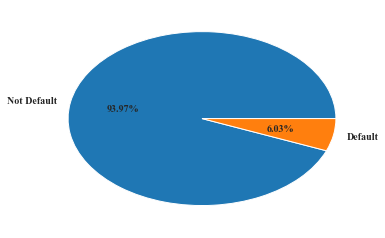

In [58]:
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = 2022)
plt.pie([(y_training==0).sum(),(y_training!=0).sum()], labels=["Not Default","Default"], autopct='%.2f%%')
plt.show()

从上面的扇形统计图中可以看出, 正负类的样本极度不均衡, 比例约为14:1. 这意味着我们需要进行一些数据平衡的操作. 然而, 对于不同的样本集, 我们可以有不同的数据平衡方式. 为此, 我们必须选择一个合适的采样方式. 我们下面根据最简单的RandomForest的结果来进行采样方式的选择

### 采样方式

In [59]:
# 不进行采样的结果基准
seed_pool=[1,20, 123,2022, 3212]
res=[]
for seed in seed_pool:
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    print(y_training.sum()/y_training.count())
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

0.06013206848861445
0.06072618189609833
0.05995675633558642
0.06033659933381382
0.05975222549038705
[0.8556464301046727, 0.8521495456876935, 0.8476842705079453, 0.8540675014527424, 0.8444777156426521]


0.8508050926791413

In [60]:

# SMOTE 过采样
res=[]
for seed in seed_pool:
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    smo = SMOTE(random_state=seed)
    X_training, y_training = smo.fit_resample(X_training, y_training)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()


[0.849730983565109, 0.8457783197765422, 0.8370517342983778, 0.8445276302175604, 0.8388904885874167]


0.8431958312890012

In [61]:
# Random 过采样
res=[]
for seed in seed_pool:
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    ros=RandomOverSampler(random_state=seed)
    X_training, y_training = ros.fit_resample(X_training, y_training)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

[0.8552690563952596, 0.8511821660575478, 0.8457126345073315, 0.8531345718771812, 0.8445020361226102]


0.8499600929919862

In [62]:
#ADASYN过采样

res=[]
for seed in seed_pool:
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    ada=ADASYN(random_state=seed)
    X_training, y_training = ada.fit_resample(X_training, y_training)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

[0.848569296383836, 0.8433104673668779, 0.8366178908382343, 0.8432745620501083, 0.8378170432893609]


0.8419178519856836

In [63]:
# Random 欠采样

res=[]
for seed in seed_pool:
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    rus=RandomUnderSampler(random_state=seed)
    X_training, y_training = rus.fit_resample(X_training, y_training)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

[0.8560673074893077, 0.850607122581669, 0.845806286528844, 0.8535305453839288, 0.8451973157261198]


0.8502417155419739

In [64]:
#SMOTEENN 组合采样

res=[]
for seed in tqdm(seed_pool):
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    se=SMOTEENN(random_state=seed)
    X_training, y_training = se.fit_resample(X_training, y_training)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

100%|██████████| 5/5 [01:19<00:00, 15.94s/it]

[0.850704681465739, 0.8465083366945864, 0.8373050900293687, 0.8450628407613878, 0.8394582884177473]


0.8438078474737658

In [65]:
# SMOTETomek 组合采样
res=[]
for seed in tqdm(seed_pool):
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    se=SMOTETomek(random_state=seed)
    X_training, y_training = se.fit_resample(X_training, y_training)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

100%|██████████| 5/5 [01:28<00:00, 17.76s/it]

[0.8495528989122326, 0.8456281119141383, 0.8374411822111962, 0.8434634185441222, 0.8391746664248894]


0.8430520556013157

综合上面的采样方式, 似乎random的过采样和random的降采样是最好的两个选择, 之前我们用的都是充分平衡数据, 这意味着我们可能忽略了一些数据分布的先验信息, 下面针对random过采样和random欠采样尝试一下不那么平衡的样本

100%|██████████| 14/14 [05:05<00:00, 21.83s/it]


ValueError: x and y must have same first dimension, but have shapes (8,) and (14,)

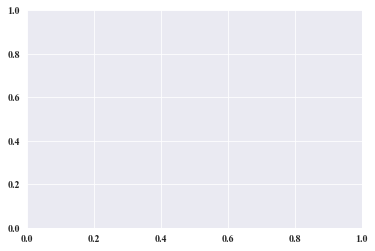

In [66]:
# Random 过采样
result=[]
for rate in tqdm(np.arange(1,15)):
    rate=1/rate
    res=[]
    for seed in seed_pool:
        X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
        ros=RandomOverSampler(random_state=seed, sampling_strategy=rate)
        X_training, y_training = ros.fit_resample(X_training, y_training)
        model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
        model.fit(X_training,y_training)
        auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
        res.append(auc_res)
    result.append(np.array(res).mean())
plt.plot(np.arange(0.2,1,0.1), result)
plt.plot(1/np.arange(1,15), result)

In [ ]:
# Random 欠采样

result=[]
for rate in tqdm(np.arange(1,15)):
    rate=1/rate
    res=[]
    for seed in seed_pool:
        X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
        rus=RandomUnderSampler(random_state=seed, sampling_strategy=rate)
        X_training, y_training = ros.fit_resample(X_training, y_training)
        model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
        model.fit(X_training,y_training)
        auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
        res.append(auc_res)
    result.append(np.array(res).mean())

plt.plot(1/np.arange(1,15), result)

遵循上面的两幅图, 我们发现当过采样时, 模型随着过采样数的增加性能不断下降. 而当欠采样时, 有一个比较稳定的平台. 因此我们最终选择欠采样方法, 采样比例为1-0=1:5, 也就是sampling strategy=0.2

最后一个问题是, 集成可以让结果变得更好吗? 我们来看用随机森林进行的easy ensemble的结果, 发现结果有一定的不太明显的提高, 因此这也为我们后面进一步集成提供了想法

In [ ]:
# 集成
res=[]
for seed in tqdm(seed_pool):
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    ee=EasyEnsembleClassifier(random_state=0, n_estimators=20,base_estimator=model, sampling_strategy=0.2)
    ee.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, ee.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

In [ ]:
# 定义训练集和验证集
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = 2022)
rus=RandomUnderSampler(random_state=2022, sampling_strategy=0.2)
X_training, y_training=rus.fit_resample(X_training,y_training)

#定义一个5组数据的集合, 用于调参
seed_list=[1,11,101,1001,2022]
X_train_5, y_train_5, X_test_5,y_test_5=[],[],[],[]
for seed in seed_list:
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    rus=RandomUnderSampler(random_state=seed, sampling_strategy=0.2)
    X_training, y_training=rus.fit_resample(X_training,y_training)
    X_train_5.append(X_training)
    y_train_5.append(y_training)
    X_test_5.append(X_validation)
    y_test_5.append(y_validation)

## 线性模型构建
### Logistic 回归
首先先使用线性Logistic分类器

In [ ]:
stdsc=StandardScaler()
X_training_std=stdsc.fit_transform(X_training)
X_validation_std=stdsc.fit_transform(X_validation)
lr=LogisticRegression()
lr.fit(X_training_std,y_training)
print('Training accuracy:', lr.score(X_training_std, y_training))
print('Test accuracy:', lr.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,lr.predict(X_validation_std)))
confusion(X_validation_std, lr)
AUC_ROC(X_validation_std,lr)

logistic分类器的性能显然不能让我们满意, 我们下面考虑SVM分类器



### SVM
众所周知, SVM当有了核函数以后是不适合大量数据的. 我们先简单试一下线性核

In [ ]:
stdsc=StandardScaler()
X_training_std=stdsc.fit_transform(X_training)
X_validation_std=stdsc.fit_transform(X_validation)
clf= svm.LinearSVC().fit(X_training_std, y_training)
print('Training accuracy:', clf.score(X_training_std, y_training))
print('Test accuracy:', clf.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,clf.predict(X_validation_std)))
confusion(X_validation_std, clf)

从 F1 value来看, 相比于最简单的logistics回归, SVM并没有明显的优势. 事实上, 这也是可以理解的. 因为SVM在更多情况下适合样本量较小但特征很多的数据, 对于我们这里的数据集并不适用, 并且训练也会很慢. 我们可以直接排除SVM模型

## 树家族

### 随机森林
作为非常有效的手段, 让我们来使用树家族算法, 首先是随机森林. 树算法无需对数据做标准化处理

In [ ]:
rfc=RandomForestClassifier(n_estimators=500, n_jobs=-1)
rfc.fit(X_training,y_training)
print('Training accuracy:', rfc.score(X_training, y_training))
print('Test accuracy:', rfc.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,rfc.predict(X_validation)))
confusion(X_validation, rfc)
AUC_ROC(X_validation,rfc)

随机森林的初步效果看起来比较一般, 但这很明显是因为过拟合的缘故. 我们来对超参数进行一定的搜索

In [ ]:
# 参数n_estimators
params_list=[10, 25, 50, 100, 150,200,250, 300,400, 500]
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=RandomForestClassifier(n_estimators=params, n_jobs=-1)
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

可以看出, 在交叉验证中, 平均auc的结果随着n_estimators的增大而不断增大. 但在100以后增加的幅度不明显. 当n_estimators越大时, 过拟合的可能性越大, 且训练速度有所下降. 因此我们会选择一个折中的参数, n_estimators=400

In [ ]:
# 参数max_depth
params_list=np.arange(2,22,2)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=RandomForestClassifier(n_estimators=400,max_depth=params,n_jobs=-1)
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

上面的图表明了当深度过深的时候, 会发生过拟合, 样本外效果急速下降. 而当深度在8-14的时候, 有一个比较稳定的峰, 因此我们选择深度的参数为11

In [ ]:
# 参数min_samples_leaf
params_list=[1, 2, 3, 4, 5, 8, 10, 15, 20]
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=RandomForestClassifier(n_estimators=400,max_depth=11, min_samples_leaf=params,n_jobs=-1)
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

In [ ]:
# 参数min_samples_leaf 继续搜索
params_list=np.arange(10,20,1)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=RandomForestClassifier(n_estimators=400,max_depth=11, min_samples_leaf=params,n_jobs=-1)
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

尽管这里的峰值并不足够稳定, 但我们仍然可以粗略的看出, 当参数在14-20之间的时候, 可以预期得到一个比较好的结果. 因此在这里我们选择参数为16

In [ ]:
# max_samples
params_list=[None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=RandomForestClassifier(n_estimators=400,max_depth=11, min_samples_leaf=16, max_samples=params,n_jobs=-1)
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

结合理论的先验认识和图像, 我们可以选择参数为0.5

In [ ]:
rfc=RandomForestClassifier(n_estimators=400,max_depth=11, min_samples_leaf=16, max_samples=0.5,n_jobs=-1)
rfc.fit(X_training,y_training)
print('Training accuracy:', rfc.score(X_training, y_training))
print('Test accuracy:', rfc.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,rfc.predict(X_validation)))
confusion(X_validation, rfc)
AUC_ROC(X_validation,rfc)

### 极端随机森林.
极端随机森林因为随机选择的特性, 会比随机森林有着更好的泛化能力. 由于过拟合的威胁, 我们很自然地会尝试一下极端随机森林做法. 首先是不进行剪枝的极端随机森林

In [ ]:
erfc=ExtraTreesClassifier(n_estimators=500, n_jobs=-1)
erfc.fit(X_training,y_training)
print('Training accuracy:', erfc.score(X_training, y_training))
print('Test accuracy:', erfc.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,erfc.predict(X_validation)))
confusion(X_validation, erfc)
AUC_ROC(X_validation,erfc)

与随机森林算法相同, 不剪枝的极端随机森林有着比较大的过拟合的风险, 我们还是进行一定的剪枝操作. 下面是整个调参的过程

In [ ]:
# 参数n_estimators
params_list = [10, 25, 50, 100, 150,200,250, 300,400, 500]
res = []
res_avg = []
for params in tqdm(params_list):
    model = ExtraTreesClassifier(n_estimators=params, n_jobs=-1)
    tmp = avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

可以看出, 平均auc的结果随着n_estimators的增大而不断增大. 但在100以后增加的幅度不明显. 当n_estimators越大时, 过拟合的倾向越明显, 且训练速度有所下降. 因此我们会选择一个折中的参数, n_estimators=200

In [ ]:
# 参数max_depth
params_list = np.arange(2, 22, 2)
res = []
res_avg = []
for params in tqdm(params_list):
    model = ExtraTreesClassifier(n_estimators=200, max_depth=params, n_jobs=-1)
    tmp = avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

上面的图表明了当深度过深的时候, 会发生过拟合, 样本外效果急速下降. 而当深度在12-16的时候, 有一个比较稳定的峰, 因此我们选择深度的参数为14

In [ ]:
# 参数min_samples_leaf
params_list=[1, 2, 3, 4, 5, 8, 10, 15, 20]
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=ExtraTreesClassifier(n_estimators=200, max_depth=14, min_samples_leaf=params,n_jobs=-1)
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

因此, 我们选择min_sample_leaf的参数值为8

In [ ]:
erfc=ExtraTreesClassifier(n_estimators=200, n_jobs=-1, max_depth=14, min_samples_leaf=8)
erfc.fit(X_training,y_training)
print('Training accuracy:', erfc.score(X_training, y_training))
print('Test accuracy:', erfc.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,erfc.predict(X_validation)))
confusion(X_validation, erfc)
AUC_ROC(X_validation,erfc)

### XGBoost Tree
XGBoost是一个典型的gradient boosting decision tree. 其效果一般要远超上面两个模型

In [ ]:
xgb=XGBClassifier(   eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=15,
                     min_child_weight=2,
                    )
xgb.fit(X_training,y_training)
print('Training accuracy:', xgb.score(X_training, y_training))
print('Test accuracy:', xgb.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,xgb.predict(X_validation)))
confusion(X_validation, xgb)
AUC_ROC(X_validation,xgb)

下面是整个调参的过程

In [ ]:
# max_depth 调参

params_list=np.arange(1,15,1)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=XGBClassifier(
                     eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=params,
                     min_child_weight=2,
                     scale_pos_weight=5
                    )
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

很明显, 在depth=4时有一个比较好的峰值, 因此我们可以取max_depth=4

In [ ]:
# scale_pos_weight 调参

params_list=np.arange(1,10,1)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=XGBClassifier(
                     eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=4,
                     min_child_weight=2,
                     scale_pos_weight=params
                    )
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

In [ ]:
params_list=np.arange(1,10,1)/10
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=XGBClassifier(
                     eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=4,
                     min_child_weight=2,
                     scale_pos_weight=params
                    )
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

很明显, 当scale_pos_weight=0.5时, 有一个不错的峰值. 因此, 取该参数为0.5

In [ ]:
# min_child_weight 调参

params_list=np.arange(1,14,2)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=XGBClassifier(
                     eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=4,
                     min_child_weight=params,
                     scale_pos_weight=0.5
                    )
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

图像中找不到一个明显的峰值, 那么我们就本着简化的原则, 采取参数为1

In [ ]:
# subsample 调参
params_list=np.arange(0.1,1,0.1)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=XGBClassifier(
                     eta=0.1,
                     colsample_bytree=0.5,
                     subsample=params,
                     max_depth=4,
                     min_child_weight=1,
                     scale_pos_weight=0.5
                    )
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

大体上, 效果随着该参数的增加而增加, 而改参数的默认值为1, 本着约简原则, 我们取该参数为1

In [ ]:
# colsample_bytree 调参
params_list=np.arange(0.1,1,0.1)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=XGBClassifier(
                     eta=0.1,
                     colsample_bytree=params,
                     subsample=1,
                     max_depth=4,
                     min_child_weight=1,
                     scale_pos_weight=0.5
                    )
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

大于0.3以后差距不大, 因此我们选择一个比较稳健的参数0.5

In [ ]:
xgb=XGBClassifier(   eta=0.1,
                     colsample_bytree=0.5,
                     subsample=1,
                     max_depth=4,
                     min_child_weight=1,
                     scale_pos_weight=0.5
                    )
xgb.fit(X_training,y_training)
print('Training accuracy:', xgb.score(X_training, y_training))
print('Test accuracy:', xgb.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,xgb.predict(X_validation)))
confusion(X_validation, xgb)
AUC_ROC(X_validation,xgb)

## 多个模型集成

In [ ]:
# 直接voting

clf1=LogisticRegression()
clf2=RandomForestClassifier(n_estimators=400,max_depth=11, min_samples_leaf=16, max_samples=0.5,n_jobs=-1)
clf3=ExtraTreesClassifier(n_estimators=200, n_jobs=-1, max_depth=14, min_samples_leaf=8)
clf4=XGBClassifier(   eta=0.1,
                     colsample_bytree=0.5,
                     subsample=1,
                     max_depth=4,
                     min_child_weight=1,
                     scale_pos_weight=0.5
                    )
vclf=VotingClassifier(estimators=[('rf', clf2), ('erf', clf3), ('xgb', clf4)],voting="soft",weights=[0.35,0.25,0.3])
vclf = vclf.fit(X_training,y_training)
print('Training accuracy:', vclf.score(X_training, y_training))
print('Test accuracy:', vclf.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,vclf.predict(X_validation)))
confusion(X_validation, vclf)
AUC_ROC(X_validation,vclf)

In [ ]:
# 先各自bagging, 最后voting
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = 2022)
clf1=RandomForestClassifier(n_estimators=400,max_depth=11, min_samples_leaf=16, max_samples=0.5,n_jobs=-1)
ee1=EasyEnsembleClassifier(random_state=0, n_estimators=5,base_estimator=clf1, sampling_strategy=0.2)
ee1.fit(X_training,y_training)
print('Training accuracy:', ee1.score(X_training, y_training))
print('Test accuracy:', ee1.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,ee1.predict(X_validation)))
confusion(X_validation, ee1)
AUC_ROC(X_validation,ee1)

In [ ]:
clf2=ExtraTreesClassifier(n_estimators=200, n_jobs=-1, max_depth=14, min_samples_leaf=8)
ee2=EasyEnsembleClassifier(random_state=0, n_estimators=10,base_estimator=clf2, sampling_strategy=0.2)
ee2.fit(X_training,y_training)
print('Training accuracy:', ee2.score(X_training, y_training))
print('Test accuracy:', ee2.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,ee2.predict(X_validation)))
confusion(X_validation, ee2)
AUC_ROC(X_validation,ee2)

In [ ]:
clf3=XGBClassifier(   eta=0.1,
                     colsample_bytree=0.5,
                     subsample=1,
                     max_depth=4,
                     min_child_weight=1,
                     scale_pos_weight=0.5
                    )
ee3=EasyEnsembleClassifier(random_state=0, n_estimators=50,base_estimator=clf3, sampling_strategy=0.2)
ee3.fit(X_training,y_training)
print('Training accuracy:', ee3.score(X_training, y_training))
print('Test accuracy:', ee3.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,ee3.predict(X_validation)))
confusion(X_validation, ee3)
AUC_ROC(X_validation,ee3)


In [ ]:
# 最终voting
rus=RandomUnderSampler( sampling_strategy=0.2)
pipe1=make_pipeline(rus, vclf)
vclf2=VotingClassifier(estimators=[ ('rf',ee1), ('xgb', ee3)],voting="soft")
vclf2 = vclf2.fit(X_training,y_training)
print('Training accuracy:', vclf2.score(X_training, y_training))
print('Test accuracy:', vclf2.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,vclf2.predict(X_validation)))
confusion(X_validation, vclf2)
AUC_ROC(X_validation,vclf2)
res1=vclf2.fit(X_train, y_train)
res1=res1.predict_proba(X_test)


# 最终结果展示

In [ ]:
abey=pd.Series(res1[:,0])
score=abey.rank()
score=(score-score.min())/(score.max()-score.min())*600+300
score=np.ceil(score).astype(int)